[View in Colaboratory](https://colab.research.google.com/github/planewave/coherent_receiver_with_CNN/blob/master/naive_IQ2phase.ipynb)

In [1]:
!pip3 -q install torch
import torch
from torch import nn
import numpy as np
torch.__version__

tcmalloc: large alloc 1073750016 bytes == 0x598c4000 @  0x7fc91d0fd1c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8


'0.4.1'

In [0]:
#@title
def rrcosdesign(beta, span, sps):
    """
    returns the coefficients, that correspond to a square-root raised 
    cosine FIR filter with rolloff factor specified by beta. The filter 
    is truncated to span symbols, and each symbol period contains sps 
    samples. The order of the filter, sps*span, must be even. 
    modified from:
    https://github.com/veeresht/CommPy/blob/master/commpy/filters.py
    """
    n = sps*span
    rrc = np.zeros(n, dtype=float)
        
    for x in np.arange(n):
        t = (x-n/2)/sps
        if t == 0.0:
            rrc[x] = 1.0 - beta + (4*beta/np.pi)
        elif beta != 0 and t == 1/(4*beta):
            rrc[x] = ((beta/np.sqrt(2))*(((1+2/np.pi)*(np.sin(np.pi/
                     (4*beta)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*beta))))))
        elif beta != 0 and t == -1/(4*beta):
            rrc[x] = ((beta/np.sqrt(2))*(((1+2/np.pi)*(np.sin(np.pi/
                     (4*beta)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*beta))))))
        else:
            rrc[x] = ((np.sin(np.pi*t*(1-beta))+4*beta*(t)*np.cos(np.pi*
                     t*(1+beta)))/(np.pi*t*(1-(4*beta*t)*(4*beta*t))))
        
    return rrc

def upsample(x, n):
    """
    increase sample rate by integer factor
    y = upsample(x,n) increases the sample rate of x by 
    inserting n – 1 zeros between samples.
    input is 1D numpy array
    
    """
    zo = np.zeros((len(x), n), dtype=x.dtype)
    zo[:,0] += x
    return zo.flatten()

In [0]:
# get the CNN, optimizer and loss func ready
CUDA = True
LR = 1e-3 # learning rate
dtype = torch.float

class NET(nn.Module):
    def __init__(self):
        super(NET, self).__init__()
        
        # find the IQ component of each symbol
        # down sample by 16
        self.cnn_1 = nn.Sequential(
        # in_channels, out_channels, kernel_size, stride, padding
            nn.Conv1d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 16, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 8, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(8, 4, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(4, 2, 3, 1, 1),
            )
        

        
        self.cnn_2 = nn.Sequential(
            nn.Conv1d(1, 16, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 8, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(8, 4, 3, 1, 1),
            )
        self.lin_2 = nn.Linear(32, 1)

    def forward(self, x, carr_off, time_cfo):
        # down convert, output absolute symbol phase
        symb_IQ = self.cnn_1(x) #[batch, 1, 32]
        # convert IQ to phase
        symb_phase = torch.atan2(symb_IQ[:, 0, :],symb_IQ[:, 1, :])
        # remove carrier introduced phase
        symb_phase = (symb_phase-carr_off-np.pi)%(2*np.pi)-np.pi
        
        # estimate CFO
        x2 = symb_phase.unsqueeze(1) #[batch, 32] to [batch, 1, 32]
        cnn_out2 = self.cnn_2(x2) 
        cfo = self.lin_2(cnn_out2.view(cnn_out2.size(0), -1))
        # [batch, 1]
        
        # apply CFO
        cfo_mat = cfo.mm(time_cfo) # [batch, 1]*[1, 32]=[batch, 32]
        symb_phase_comp = (symb_phase+cfo_mat-np.pi)%(2*np.pi)-np.pi
        
        return symb_phase_comp
    
net = NET()


if CUDA:
    device = torch.device('cuda:0')
    net.cuda()
else:
    device = torch.device('cpu')
    

optimizer = torch.optim.Adam(net.parameters(), lr=LR)
# loss_func = nn.MSELoss()

def circ_loss(input, target, cyc):
    """
    a circular MSE loss 
    """
    dif = torch.abs(input-target)
    dif[dif>cyc/2] = dif[dif>cyc/2]-cyc
#     return torch.mean(dif**2)
    return dif.abs().mean()

# sanity test 
# beta, span, sps = 0.4, 16, 16
# nSymb = 32
# batch = 128
# x = torch.rand(batch, 1, nSymb*sps, dtype = dtype, device = device)
# out = net(x) #[128, 2, 32]
# phase = torch.atan2(out[:, 0, :],out[:, 1, :])
# target = torch.rand(batch, nSymb, dtype = dtype, device = device)
# target.shape
# loss = circ_mse_loss(phase, target, 2*np.pi)
# loss




In [7]:
M = 4 # QPSK
SYMB = 32 # num of symbols
BATCH = 256
beta, span, sps = 0.4, 6, 16
rrc = rrcosdesign(beta, span, sps)
fc = 5.0e3 # carrier freq
baud = 1.1e3 

# note there is an assumption that timing is perfect
fs = baud*sps # signal sample rate 16k>2*fc
# initialization
sig_batch = np.zeros((BATCH, 1, SYMB*sps)) #(128, 1, 512)
msg_batch = np.zeros((BATCH, SYMB))

carr_off = 2*np.pi*fc/baud*torch.arange(0, SYMB).float()
time_cfo = torch.arange(0, SYMB).float().view(1, -1)

if CUDA:
    carr_off = carr_off.cuda()
    time_cfo = time_cfo.cuda()

cyc = 2*np.pi

for epoch in range(501):
    # 准备输入数据
    for batch in range(BATCH):
        # 数据格式: numpy 多维数组
        msg = np.random.randint(0, M, SYMB) # 0~3
        sig_mod = np.exp(1j*(np.pi/M+msg*(2*np.pi/M))) # k/4*pi k=0~3
        sig_phase = np.angle(sig_mod)
        # pluse shaping 
        sig_up = upsample(sig_mod, sps) # SYMB*sps (512,)
        sig_pulse = np.convolve(sig_up, rrc) # (607,)
        # up convert
        samp_len = len(sig_pulse)
        time_carr = np.arange(samp_len)/fs
        
        
        cfo = np.random.rand()*20-10 # include CFO
        carrier = np.exp(1j*(2*np.pi*(fc+cfo)*time_carr))
        sig_pass = np.real(sig_pulse*carrier)# (607,)
        noise = 0.04*np.random.randn(sig_pass.size)
        sig_pass = sig_pass+noise
        sig_batch[batch, 0, :] = sig_pass[int(rrc.size/2):int(-rrc.size/2+1)]
        msg_batch[batch, :] = sig_phase
        
    # numpy to torch tensor    
    sig_input = torch.tensor(sig_batch, dtype = dtype, device=device) 
    target = torch.tensor(msg_batch, dtype = dtype, device=device) #[128, 32]
    # training

        
    phase_est = net(sig_input, carr_off, time_cfo) #[256, 2, 32]
#     phase_est = torch.atan2(y_est[:, 0, :],y_est[:, 1, :])
#     phase_est = (phase_est-2*np.pi*fc/baud*torch.arange(0, SYMB)
#                  .float().cuda()-np.pi)%(2*np.pi)-np.pi

    loss = circ_loss(phase_est, target, cyc)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch%50==0:
        degree = loss.item()/np.pi*180
        print("epoch = ",epoch, "; loss = %7.4f"% degree)


epoch =  0 ; loss = 32.7171
epoch =  50 ; loss = 32.7330
epoch =  100 ; loss = 30.6420
epoch =  150 ; loss = 28.1851
epoch =  200 ; loss = 27.3395
epoch =  250 ; loss = 26.4350
epoch =  300 ; loss = 22.7120
epoch =  350 ; loss = 21.6147
epoch =  400 ; loss = 22.6379
epoch =  450 ; loss = 19.9193
epoch =  500 ; loss = 18.7950


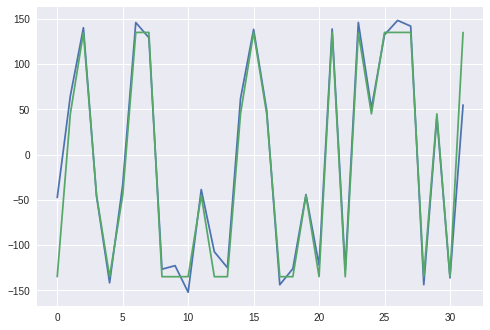

13.462303

In [8]:
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(0,32)
y1 = phase_est[41].cpu().detach().numpy()/np.pi*180
y2 = target[41].cpu().detach().numpy()/np.pi*180
plt.plot(x, y1)
plt.plot(x, y2)
plt.show()
np.mean(np.abs(y1-y2))
# phase_est[0].cpu().detach().numpy()

